# Práctica - Árboles y random forest para regresión

Master en Inteligencia Artificial - UNIR

## Objetivos de la actividad

Aplicar al conjunto de datos proporcionado los métodos o algoritmos Árboles y Random Forest para predecir (regresión) el número de ventas de bicicletas por hora. (La variable cnt describre la cantidad de bicicletas rentadas en una hora específica)

### Primera parte: Análisis exploratorio de los datos.

In [1]:
# Se importan las librerías necesarias para la ejecución del proceso

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline 

In [2]:
# Se carga el archivo con los datos de ventas por hora archivo: hour.csv
df_hour = pd.read_csv('hour.csv')
df_hour

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


En el conjunto de datos se tiene un total de 17.379 registros que contienen las siguientes columnas:

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

A continuación se realiza un análisis de los datos con relación a la variable cnt que es la variable objetivo del problema de aprendizaje automático.

In [3]:
#Se revisan los datos correspondientes a las ventas por día , mes y por horas

#Se totalizan los valores por dia
total_alquires_dia = df_hour.groupby('dteday')['cnt'].sum().reset_index()
x_labels = total_alquires_dia.iloc[0:len(total_alquires_dia.index):100]

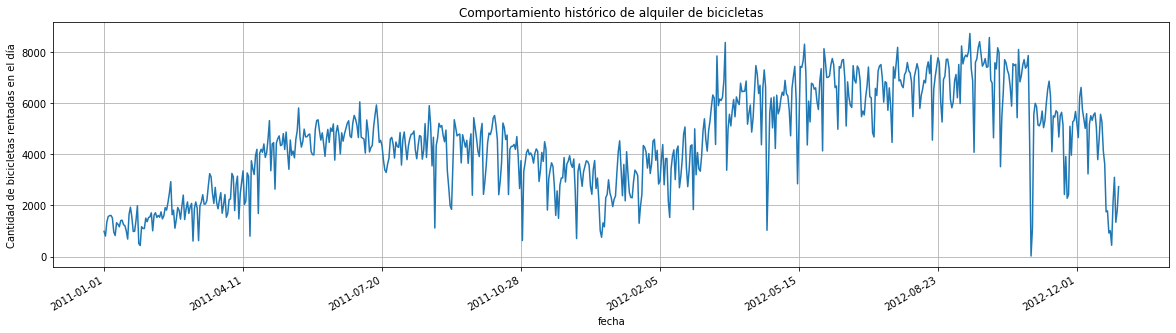

In [4]:
# Se genera la gráfica de comportamiento del alquileres de bicicletas por días.
fig = plt.figure(figsize=(20, 5))

sns.lineplot(x=total_alquires_dia['dteday'], y=total_alquires_dia['cnt'])
plt.xticks(x_labels['dteday'], rotation=90)
fig.autofmt_xdate()
plt.ylabel('Cantidad de bicicletas rentadas en el día')
plt.xlabel('fecha')
plt.title('Comportamiento histórico de alquiler de bicicletas')
plt.grid(True)

En esta gráfica se puede observar la evolución de la cantidad de bicicletas rentadas por día entre los años 2011 y 2012. Se observa que se tienen periodos de crecimiento pero se tienen cambién caídas significativas para periodos específicos.

Text(0, 0.5, 'Frecuencia')

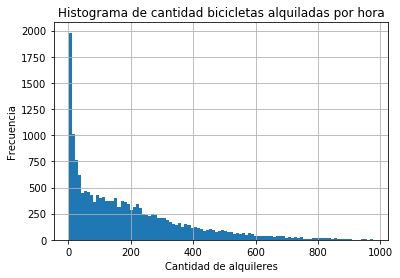

In [5]:
# Ahora se analiza el comportamiento del alquiler de bicicletas mediante un análisis de frecuenta
# de la cantidad de bicicletas alquiladas por día

df_hour['cnt'].hist(bins=100)
plt.title('Histograma de cantidad bicicletas alquiladas por hora')
plt.xlabel('Cantidad de alquileres')
plt.ylabel('Frecuencia')

In [6]:
# Se realiza un analisis estadístico de los datos de la variable cnd mediante la funciónd describe()
df_hour['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

En este análisis se puede observar que el mínimo de bicicletas alquiladas en una hora es 1 y el máximo de 977.
En promedio por hora se alquilan 189 bicicletas. 

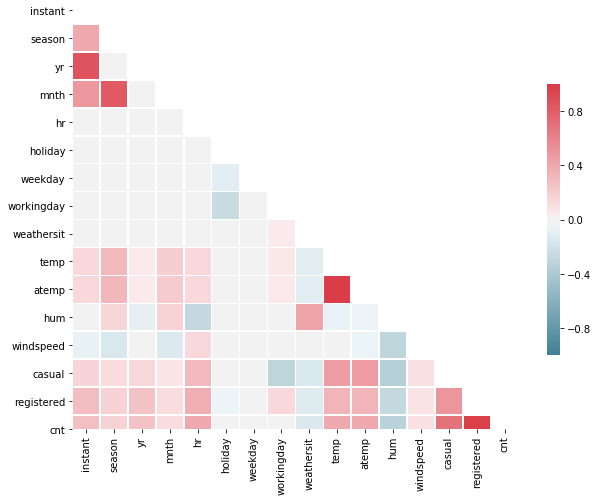

In [7]:
# Se realiza un análisis de correlación de las variables del conjutno de datos 
# humedad, velocidad del viento

#Se calcula la matriz de correlación de los datos
df_correlations = df_hour.corr()

mask = np.zeros_like(df_correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize= (10,10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,mask=mask,  vmax=1, vmin=-1, cmap=cmap, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});


En el análisis de correlación se evidencia algunas correlaciones lógicas como el mes con la temporada, la temperatura con la temperatura normalizada en grados Celsius, y la cantidad de alquileres con respecto a los usuarios registrados y casuales (cnt es la suma de estas dos variables.) con respecto a la variable objetivo la cual corresponde a la cantidad de alquileres (cnt) se puede observar lo siguiente:

La hora no tiene una correlación significativa con la cantidad. Por esto es necesario realizar un análisis un poco más detallado del comportamiento por hora de los alquileres de bicicletas.

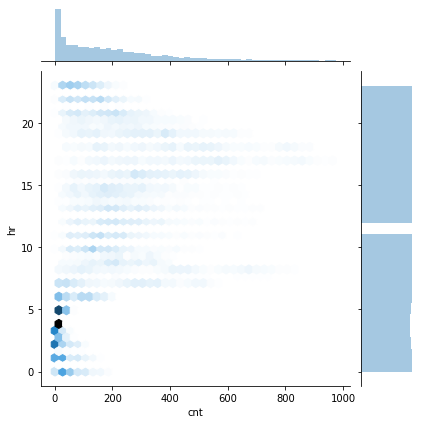

In [72]:
# Se realiza una gráfica de comparación de las variables cnt y hora (hr)
sns.jointplot(df_hour['cnt'], df_hour['hr'], kind="hex")

Está gráfica muestra que la relación entre las varibles está truncado, dado que la distribución de frecuencias corresponde a una gráfica de larga cola.

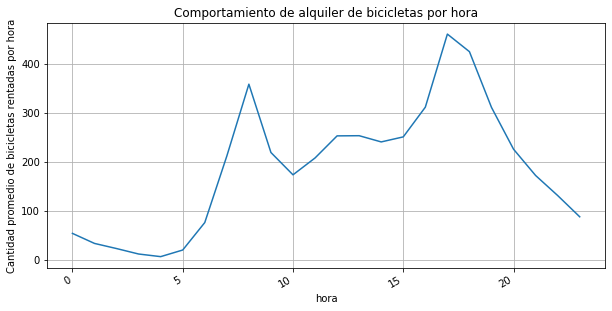

In [9]:
#Se totalizan los valores por hora
promedio_alquires_hora = df_hour.groupby('hr')['cnt'].mean().reset_index()

# Se genera la gráfica de comportamiento del alquileres de bicicletas por hora y el promedio de alquileres 
fig = plt.figure(figsize=(10, 5))

sns.lineplot(x=promedio_alquires_hora['hr'], y=promedio_alquires_hora['cnt'])
fig.autofmt_xdate()
plt.ylabel('Cantidad promedio de bicicletas rentadas por hora')
plt.xlabel('hora')
plt.title('Comportamiento de alquiler de bicicletas por hora')
plt.grid(True)

En esta gráfica se puede observar que las horas en las cuales se tiene un valor promedio más alto de alquileres correponde a la mañana entre las 7 am y las 9 am y en la tarde ente las 5 pm y las 7 pm, las cuales corresponden a los horarios de ingreso y salida de las oficinas lo cual de alguna manera corresponde con un comportamiento posible. Otra posible observación corresponde a que en las horas de la tarde em promedio las personas utilizan más el servicio de bicicleta para regresar a sus hogares.

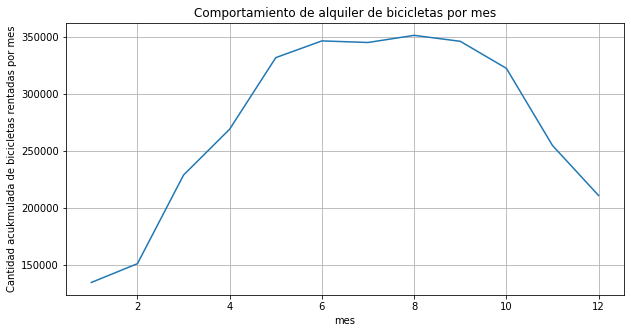

In [10]:
# Ahora se realiza una revisión del comportamiento de los alquileres promedio por mes
promedio_alquires_mes = df_hour.groupby('mnth')['cnt'].sum().reset_index()

# Se genera la gráfica de comportamiento del alquileres de bicicletas por hora y el promedio de alquileres 
fig = plt.figure(figsize=(10, 5))

sns.lineplot(x=promedio_alquires_mes['mnth'], y=promedio_alquires_mes['cnt'])
plt.ylabel('Cantidad acukmulada de bicicletas rentadas por mes')
plt.xlabel('mes')
plt.title('Comportamiento de alquiler de bicicletas por mes')
plt.grid(True)

En esta gráfica se puede observar que la cantidad de bicicletas rentadas se incrementa para los meses de mayo - septiemmbre que corresponden a los meses de verando donde el clima es más apropiado para el uso de la bicicleta.

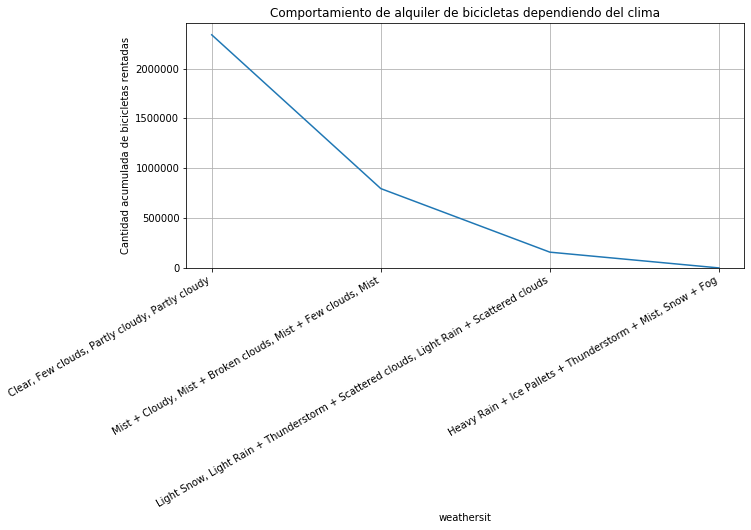

In [11]:
# Otra comparación que se realiza es la cantidad de bicicletas rentadas dependiendo del clima
promedio_alquires_clima = df_hour.groupby('weathersit')['cnt'].sum().reset_index()

# Se genera la gráfica de comportamiento del alquileres de bicicletas por hora y el promedio de alquileres 
fig = plt.figure(figsize=(10, 5))

sns.lineplot(x=promedio_alquires_clima['weathersit'], y=promedio_alquires_clima['cnt'])
fig.autofmt_xdate()
plt.xticks([1,2,3,4],['Clear, Few clouds, Partly cloudy, Partly cloudy','Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
           'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
            'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'])
plt.ylabel('Cantidad acumulada de bicicletas rentadas')
plt.title('Comportamiento de alquiler de bicicletas dependiendo del clima')
plt.ylim(ymin=0)
plt.grid(True)

En la gráfica se puede observar que durante condiciones climaticas adversas como lluvia fuerte y nieve se alquilan menos bicicletas dado la dificultad de movilizarce bajo dichas condiciones.

### Conclusiones del análisis exploratorio

En el análisis exporatorio realizado se comparó la correlación de las diferentes variables y el comportamiento de la variable cnt de cantidad de bicicletas alquiladas. Como hipótesis del análisis realizado, se evidencia que variables como el estado de clima, la hora y la temporada pueden ser determinantes para la predicción del valor de cantidad de bicicletas rentadas. 

### Segunda parte: Indetificación de valores faltantes

In [12]:
# Identificar la existencia de valores nulos en el conjunto de datos
df_hour.isnull().sum(axis = 0)

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Se puede evidenciar que no se tienen datos nulos en los datasets.

In [13]:
# Pra validar los rangos de valores del conjunto de datos se ejeucta la sentencia describe para todo el dataset
df_hour.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Se puede observar en la tabla de descripción estadística que no existen vacíos en los datos. Para el desarrollo del modelo de predicción se consideran las siguientes variables resultado del análisis exploratorio realizado:

<b>VARIABLES A UTILIZAR EN EL MODELO:</b>

- Weekday
- season
- mnth
- holiday
- workingday
- weathersit
- hr
- temp
- hum
- windspeed

Las variables casual y registered tienen una correlación alta y a partir de las dos se botiene el valor cnt, por tanto no tiene mucho sentido coniderarlas como variables de entrada del modelo. la variable instant es el id del registro y la varible atemp tiene una correlación muy alta con tempo por tanto cualquiera de estas puede ser utilizada.

### Tercera parte: Determinar el conjunto de modelización y el de validación.

Para dividir los datos se utiliza la funcionalidad de división de datos de entrenamiento y prueba de la librería sklearn

In [63]:
from sklearn.model_selection import train_test_split

X=df_hour[['mnth','season', 'weekday', 'workingday', 'holiday', 'weathersit', 'hr' ,'temp', 'hum', 'windspeed']]  # Features
y=df_hour['cnt']  # Labels

# Dividir los datos de entrenamiento y de validación
# 70% de entrenamiento y 30% de validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2019) # 70% training  y 30% test

In [64]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12165, 10)
(5214, 10)
(12165,)
(5214,)


### Cuarta parte: Tratamiento de variables categóricas.

El dataset no contiene variables categóricas

# Modelos de regresión

### Quinta parte: Entrenar el modelo

Para este ejericio de regresión se van a probar cuatro modelos diferentes:

- RandomForestRegressor
- DecisionTreeRegressor

In [16]:
# Se importan las librerías correspondientes para los tres modelos
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 

Para la ejecución del proceso de entrenamiento se siguieron las recomiendas de este artículo: <b>"Hyperparameter Tuning the Random Forest in Python"</b>

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

En este artículo se detalla la recomendación de utilizar los métodos <b>RandomizedSearchCV</b> que permite realizar una búsqueda aleatoria de los hiperparámetros que presentan mejor desempeño y el método <b>GridSearchCV</b> que permite crear una malla de tangos de parámetros construidas a partir de los valores identificados con el método <b>RandomizedSearchCV</b> y aplica validación cruzada.

#### Entrenamiento Modelo de random forest

In [17]:
# se crea el conjunto de rangos de hiperparámetros para realizar la búsqueda de los valores óptimos de estos:

from sklearn.model_selection import RandomizedSearchCV

# Número de árboles
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 50)]
# Número de atributos a considerar en cada división
max_features = ['auto', 'sqrt']
# Máxima profundidad del árbol
max_depth = [int(x) for x in np.linspace(10, 60, num = 10)]
max_depth.append(None)
# Mínimo número de items considerados para realizar una división
min_samples_split = [2, 5, 10]
# mínimo número de item para crear una nueva hoja
min_samples_leaf = [1, 2, 4]
# Método de selección de muestras para cada árbol
bootstrap = [True, False]

# se crea la malla de rangos de los hiperparámetros
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# se crea el modelo base
rf = RandomForestRegressor(random_state = 2020)

# Se invoca la función RandomizedSearchCV pasando la malla de parámetros creada
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 50, scoring='neg_mean_absolute_error', 
                              cv = 5, verbose=2, random_state=2020, n_jobs=-1,
                              return_train_score=True)

rf_random.fit(X_train, y_train);

# Se muestran los hiperparámetros con mejor desempeño encontrados
rf_random.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 14.9min finished


{'n_estimators': 330,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 32,
 'bootstrap': False}

In [18]:
from sklearn.model_selection import GridSearchCV

# se crea una malla de parámetros a partir de los valores obtenidos con la función RandomizedSearchCV
param_grid = {
    'bootstrap': [False],
    'max_depth': [28, 32, 36],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [250, 300, 350]
}

# se crea el modelo base
rf = RandomForestRegressor(random_state = 2020, max_features ='sqrt')

# se pasa el modelo base y la malla de parámetros a la función 
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search.fit(X_train, y_train)

# Se muestran los hiperparámetros óptimos para el modelo
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  8.5min finished


{'bootstrap': False,
 'max_depth': 28,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

#### Entrenamiento Modelo de árbol de decisión

In [19]:
#Se crea del modelo de arbol de decisión de regresión por defecto

dtm = DecisionTreeRegressor(max_depth=4,
                           min_samples_split=5,
                           max_leaf_nodes=10)

dtm.fit(X,y)

#Se crea la malla de hiperparámetros para optimización del modelo
d_param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

#Se crea el modelo genérico con los valores de hiperparámetros
grid_cv_dtm = GridSearchCV(dtm, d_param_grid, cv=5, n_jobs = -1, verbose = 2, return_train_score=True)
grid_cv_dtm.fit(X,y)

# Se imprimen los valores óptimos de hiperparámetros
grid_cv_dtm.best_params_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 767 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  9.1min finished


{'criterion': 'mae',
 'max_depth': 8,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 20,
 'min_samples_split': 20}

[Text(0.5, 1.0, 'Efecto de la profundidad y tamaño de las hojas en el modelo')]

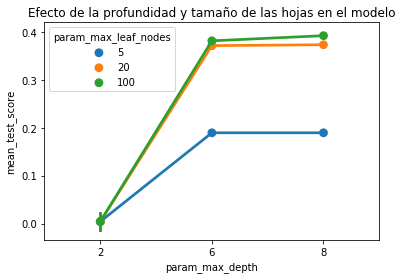

In [21]:
# Se grafica la comparación de valores de hiperparámetros encontrados
df = pd.DataFrame(data=grid_cv_dtm.cv_results_)

fig,ax = plt.subplots()
sns.pointplot(data=df[['mean_test_score',
                           'param_max_leaf_nodes',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Efecto de la profundidad y tamaño de las hojas en el modelo")

### Sexta parte: Calcular las métricas de evaluación de los modelos de regresión

In [27]:
from sklearn import metrics

# Se creauna función para evaluar el desempeño de los modelos
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

#### Desempeño del modelo random forest

In [28]:
# Se evalua el desempeño del modelo con los parámetros optimizados.
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

y_pred = best_grid.predict(X_test)
#residuals = y_test.flatten() - y_pred

# Como métricas de desempeño se calcula los valores de r y el error cuadrático medio MSE
r2_score = best_grid.score(X_test,y_test)
print("R-squared:{:.3f}".format(r2_score))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))

Model Performance
Average Error: 42.6965 degrees.
Accuracy = 51.37%.
R-squared:0.861
MSE: 4420.38


#### Desempeño del modelo de árbol de decisión para regresión

In [30]:
# Se  mide el desempeño del modelo de árbol de decisión con los parámetros óptimos
best_dtm_model = grid_cv_dtm.best_estimator_
grid2_accuracy = evaluate(best_dtm_model, X_test, y_test)

y2_pred = best_dtm_model.predict(X_test)
#residuals2 = y_test.flatten() - y_pred

# Como métricas de desempeño se calcula los valores de r y el error cuadrático medio MSE
r2_score2 = best_dtm_model.score(X_test,y_test)
print("R-squared:{:.3f}".format(r2_score2))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y2_pred))

Model Performance
Average Error: 55.1646 degrees.
Accuracy = 50.29%.
R-squared:0.751
MSE: 7891.72


### Séptima parte: Comparar los resultados obtenidos

Con la información obtenida de los regresores se obtiene la siguiente comparación:

| Model Performance |   Decision tree  |   Random Forest  |
|-------------------|:----------------:|:----------------:|
| Average Error     |  55.1646 degrees |  42.6965 degrees |
| Accuracy          |      50.29%      |      51.37%      |
| R-squared         |       0.751      |       0.861      |
| MSE               |      7891.72     |      4420.38     |

Se puede observar que el desempeño de los dos algoritmos es muy bajo casi del orden del 50%, a pesar de las optimizaciones de hiperparámetros. Esto puede ser un indicador que este tipo de algoritmos no es el más adecuado para este tipo de problemas. Como parte del ejercicio no se consideraron las variables de secuencia temporal, es decir por ejemplo fecha ya que convertiría el problema en un problema de series de tiempo. Como prueba adicional de corrió el mismo conjunto de datos con una regresor lineal para poder validar si el problema corresponde al tipo de método de regresión, a continuación, se presenta la prueba base sin optimización de hiperparámetros:

In [66]:
from sklearn.linear_model import LinearRegression

modelo_lineal = LinearRegression().fit(X_train, y_train)

y3_pred = modelo_lineal.predict(X_test)

accuracy_ml = evaluate(modelo_lineal, X_test, y_test)

r2_score3 = modelo_lineal.score(X_test,y_test)
print("R-squared:{:.3f}".format(r2_score3))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y3_pred))

Model Performance
Average Error: 106.8000 degrees.
Accuracy = -223.57%.
R-squared:0.334
MSE: 21121.50


Como resultado se observa con un resultado muy pobre utilizando el regresor lineal para este caso, demostrando la complejidad de la regresión para este modelo.

### Octava parte: Conclusiones adicionales

Como conclusión general se puede observar que el problema de regresión para este conjunto de datos, es complejo y por tanto la predicción mediante métodos de regresión requiere algoritmos más complejos el siguiente paso corresponde a realizar la prueba con sistemas de regresión más robustos como redes neuronales para validar si se pueden tener mejores resultados.

# Modelos de clasificación

Para este ejericio de clasificación se van a probar los siguientes modelos:

- RandomForestClassifier
- DecisionTreeClassifier

### Tercera parte: Determinar el conjunto de modelización y el de validación.

Para este tipo de modelo se realiza una ajuste en los datos de la variable a predecir correspondiente a trasnformar los valore según la regla 

1 -> si cnt<=20
2 - > si cnt>20

Para ello se realiza el ajuste en los datos ajustados

In [73]:
X2=df_hour[['mnth','season', 'weekday', 'workingday', 'holiday', 'weathersit', 'hr' ,'temp', 'hum', 'windspeed']]  # Features
y2=df_hour['cnt']  # Labels

y2 =  y2.apply(lambda x : 1 if (x <= 20) else 2)
y2

0        1
1        2
2        2
3        1
4        1
        ..
17374    2
17375    2
17376    2
17377    2
17378    2
Name: cnt, Length: 17379, dtype: int64

Con la variable ajustada se procede a divir los datos en los conjuntos de entrenamiento y validación

In [74]:
# Dividir los datos de entrenamiento y de validación
# 70% de entrenamiento y 30% de validación
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=2019) # 70% training  y 30% test

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12165, 10)
(5214, 10)
(12165,)
(5214,)


### Quinta parte: Entrenar el modelo

In [75]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix

#### Clasificación con SVM - Máquinas de soporte vectorial

In [76]:
svc = SVC(random_state=2020, gamma='auto')
svc.fit(X2_train, y2_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=2020, shrinking=True,
    tol=0.001, verbose=False)

#### Clasificación con RandomForestClassifier

In [96]:
rfc = RandomForestClassifier(n_estimators=100, random_state=2020)
rfc.fit(X2_train, y2_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)

#### Clasificación con DecisionTreeClassifier

In [112]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=10)
clf = clf.fit(X2, y2)

### Sexta parte: Evaluación de métricas de desempeño del modelo

In [98]:
# Se utiliza esta función classification_report para la presentación de las métricas de evaluación del modelo.

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

##### Desempeño del modelo de clasificación random forest

In [108]:
y_pred_rf =rfc.predict(X2_test)

target_names = ['Grupo 1', 'Grupo 2']
print(classification_report(y2_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

     Grupo 1       0.90      0.88      0.89       934
     Grupo 2       0.97      0.98      0.98      4280

    accuracy                           0.96      5214
   macro avg       0.94      0.93      0.93      5214
weighted avg       0.96      0.96      0.96      5214



##### Desempeño del modelo de clasificación de árbol de decisión

In [113]:
y_pred_dt =clf.predict(X2_test)
print(classification_report(y2_test, y_pred_dt, target_names=target_names))

              precision    recall  f1-score   support

     Grupo 1       0.92      0.94      0.93       934
     Grupo 2       0.99      0.98      0.99      4280

    accuracy                           0.98      5214
   macro avg       0.96      0.96      0.96      5214
weighted avg       0.98      0.98      0.98      5214



##### Desempeño del modelo de clasificación de SVM

In [110]:
y_pred_sv =svc.predict(X2_test)
print(classification_report(y2_test, y_pred_sv, target_names=target_names))

              precision    recall  f1-score   support

     Grupo 1       0.90      0.88      0.89       934
     Grupo 2       0.97      0.98      0.98      4280

    accuracy                           0.96      5214
   macro avg       0.94      0.93      0.93      5214
weighted avg       0.96      0.96      0.96      5214



### Séptima parte: Comparación de resultados

A continuación se presenta la comparación de los resultados obtenidos para los tres algoritmos utilizados:
    
| Model Performance | Decision tree | Random Forest | SVC  |
|-------------------|:-------------:|:-------------:|------|
| precision         |      0.98     |      0.96     | 0.96 |
| recall            |      0.98     |      0.96     | 0.96 |
| f1-score          |      0.98     |      0.96     | 0.96 |
| support           |      5214     |      5214     | 5214 |

Se puede observar que los tres modelos obtienen un valor de precisión y de f1-score altos indicando que logran realizar una buena clasificación de los datos. el modelo con mejor desempeño es el árbol de decisión que alcanza un score de 98%.

### Octava parte: Conclusiones adicionales del ejercición de clasificación

Como conclusión relevante se puede identificar que dataset está mejor establecido para modelos de clasificación, pero no de regresión. Los métodos de regresión mostraron un desempeño bajo que implica que la predicción de valores para es de una naturaleza muy compleja que requiere algoritmos con mayor capacidad predictiva y parte del experimento sería probar métodos alternativos para mejorar el desempeño. En cuanto a la clasificación los datos se adaptan muy bien a los algoritmos obteniendo valores destacables en las métricas de desempeño.

# Evaluación individual

|                                                                                 | Sí  | No  | A veces |
|---------------------------------------------------------------------------------|-----|-----|---------|
| Todos los miembros se han integrado al trabajo del grupo                        | X   |     |         |
| Todos los miembros participan activamente                                       | X   |     |         |
| Todos los miembros respetan otras ideas aportadas                               | X   |     |         |
| Todos los miembros participan en la elaboración del informe                     | X   |     |         |
| Me he preocupado por realizar un trabajo cooperativo con mis compañeros         | X   |     |         |
| Señala si consideras que algún aspecto del trabajo en grupo no ha sido adecuado |     |  X  |         |